In [1]:
%load_ext autoreload
%autoreload 2
%env CUDA_DEVICE_ORDER=PCI_BUS_ID
%env CUDA_VISIBLE_DEVICES=1

env: CUDA_DEVICE_ORDER=PCI_BUS_ID
env: CUDA_VISIBLE_DEVICES=1


In [2]:
from cuml.manifold.umap import UMAP as cumlUMAP

In [3]:
cuml_umap = cumlUMAP()

In [4]:
import numpy as np
import pandas as pd
from avgn.utils.paths import DATA_DIR, most_recent_subdirectory, ensure_dir
from sklearn.preprocessing import scale
import matplotlib.pyplot as plt
from tqdm.autonotebook import tqdm

/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


In [5]:
from avgn.utils.paths import DATA_DIR, most_recent_subdirectory, ensure_dir
from avgn.signalprocessing.create_spectrogram_dataset import flatten_spectrograms#

In [6]:
from avgn.visualization.projections import scatter_spec, scatter_projections
from avgn.utils.general import save_fig
from avgn.utils.paths import FIGURE_DIR, ensure_dir

In [7]:
import hdbscan

In [8]:
DATASET_ID = 'swamp_sparrow'

In [9]:
syllable_df = pd.read_pickle(DATA_DIR / 'syllable_dfs' / DATASET_ID / 'swampsparrow-taper_with_freq2.pickle')

In [10]:
syllable_df[:3]

,start_time,end_time,syllable,pos_in_syllable,peakfreq_start,peakfreq_end,indv,indvi,POPID,GRIDX,GRIDY,key,audio,rate,syll_len,f_start,f_end,spectrogram
0,0.1705,0.2145,0.0,0.0,6158.496094,5254.101562,NYHVTIV18,0,"Hudson Valley, NY",42.042489,-73.9237463,SWSP09TIV18L1,"[0.0, 0.0005278791589983579, 0.001123593156707...",44100,0.043991,5857.031250,6287.695312,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
1,0.2035,0.2550,0.0,1.0,3746.777344,4048.242188,NYHVTIV18,0,"Hudson Valley, NY",42.042489,-73.9237463,SWSP09TIV18L1,"[0.0, -0.015641441632961404, -0.04495665944855...",44100,0.051497,5469.433594,4220.507812,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
2,0.2625,0.2910,0.0,2.0,8311.816406,3875.976562,NYHVTIV18,0,"Hudson Valley, NY",42.042489,-73.9237463,SWSP09TIV18L1,"[-0.0, -0.001130732482877271, -0.0025247620611...",44100,0.028503,7795.019531,3919.042969,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."


In [11]:
len(syllable_df.indv.unique())

615

In [12]:
### get population info

In [13]:
pd.DataFrame({
    i: [np.sum(syllable_df['POPID'].values == i)]
    for i in np.unique(syllable_df['POPID'].values)
}).T.sort_values(
    by=0, ascending=False)

,0
"Conneaut, PA",31938
"Hudson Valley, NY",15527
"Horicon, WI",14825
"Adirondacks, NY",13007
"Waterloo, MI",12110
"Montezuma, NY",10091


In [14]:
specs = np.stack(syllable_df['spectrogram'].values)
#embedding = np.vstack(syllable_df['umap_0.5'].values)

In [15]:
syllable_df['f_diff_est'] = syllable_df['f_start'].values - syllable_df['f_end'].values

In [16]:
syllable_df['f_diff'] = syllable_df['peakfreq_start'].values - syllable_df['peakfreq_end'].values

In [17]:
syllable_df['syll_len'] = syllable_df['syll_len']*1000

In [18]:
syllable_df['syll_len'][:5]

0    43.990930
1    51.496599
2    28.503401
3    49.501134
4    55.510204
Name: syll_len, dtype: float64

In [19]:
embedding_freq = np.vstack([
    syllable_df['peakfreq_start'].values,
    syllable_df['peakfreq_end'].values,
]).T

In [20]:
embedding = np.vstack([
    syllable_df['syll_len']+ np.random.rand(len(syllable_df['syll_len'])),
    syllable_df['f_diff'].values #+ np.random.rand(len(syllable_df['f_diff'])),
]).T
embedding[:,0] = np.log(embedding[:,0])

(-5000, 10000)

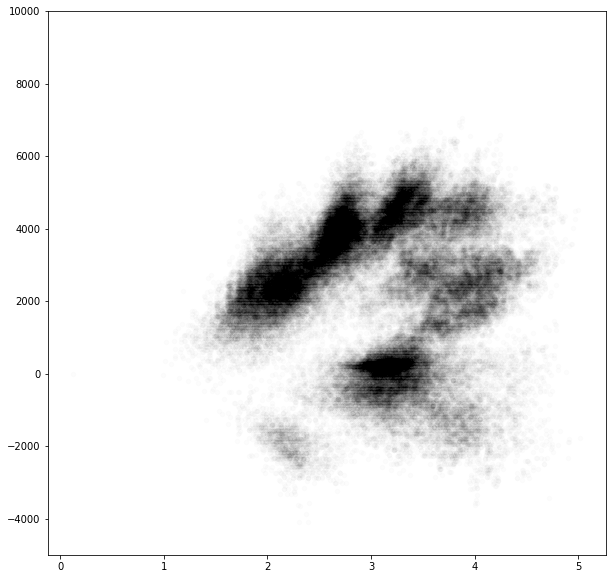

In [22]:
fig, ax = plt.subplots(figsize=(10,10))
ax.scatter(embedding[:,0],embedding[:,1],  alpha = 0.01, s=20, color='k')
#ax.set_xlim([1, 1000])
ax.set_ylim([-5000, 10000])
#ax.set_xscale('log')